# Telecom Churn Prediction

**Author:** Mallika Bera & Mamatha K

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [514]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

#Sklearn
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [515]:
# #COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

# #Checking the kaggle paths for the uploaded datasets
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [516]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv(r"C:\Users\Saurabh\OneDrive\AI_ML\ML 2\train.csv")
unseen = pd.read_csv(r"C:\Users\Saurabh\OneDrive\AI_ML\ML 2\test.csv")
sample = pd.read_csv(r"c:\Users\Saurabh\OneDrive\AI_ML\ML 2\sample.csv")
data_dict = pd.read_csv(r"C:\Users\Saurabh\OneDrive\AI_ML\ML 2\data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [517]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents


In [518]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [519]:
# ids = ['id','circle_id']
# total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
# total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
# offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
# average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
# average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
# volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
# volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
# age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

# #Storing them in a single flat list
# variables = [*ids, 
#              *total_amounts, 
#              *total_outgoing_minutes, 
#              *offnetwork_minutes, 
#              *average_revenue_3g, 
#              *average_revenue_2g,
#              *volume_3g,
#              *volume_2g,
#              *age_on_network, 
#              'churn_probability']

# data = data[variables].set_index('id')

In [520]:
# Checking the dataset information
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

## Data Cleansing

In [521]:
# Statistical analysis of the numercial columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.0,17499.5,34999.0,52498.5,69998.00
circle_id,69999.0,109.000000,0.000000,109.0,109.0,109.0,109.0,109.00
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
std_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
aon,69999.0,1220.639709,952.426321,180.0,468.0,868.0,1813.0,4337.00
aug_vbc_3g,69999.0,68.108597,269.328659,0.0,0.0,0.0,0.0,12916.22
jul_vbc_3g,69999.0,65.935830,267.899034,0.0,0.0,0.0,0.0,9165.60
jun_vbc_3g,69999.0,60.076740,257.226810,0.0,0.0,0.0,0.0,11166.21


We can see that many of the columns are having min, max, mean as 0.0. This can happen when all the entries for that column is null. 
So , we need to clean the data before we can start building our model.

In [522]:
# Checking for features/columns with all entries as 0 , NaN or unique values (zero variance). These columns will not be useful for our analysis.

unique_counts = data.nunique()
data_unique_columns = unique_counts[unique_counts == 1].index
data_unique_columns

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')

In [523]:
# Verifying data for the unique columns before dropping the features.
data[data_unique_columns]

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
69995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
69996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
69997,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0


In [524]:
# Looking at the dataset we can confirm that these columns does not show any variance in the data and can be excluded from our analysis.

#Dropping columns with unique values.
data.drop(data_unique_columns, axis=1, inplace = True)

In [525]:
# Rechecking shape of the dataframe
data.shape

(69999, 159)

In [526]:
# Checking rows with more than 50% missing values. These rows will not contribute much to our analysis so we can drop them
data_missing_rows = data[(data.isnull().sum(axis=1)) > (len(data.columns)//2)]
data_missing_rows

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
37,37,383.327,-5.00,0.000,54.41,NaN,NaN,780.21,NaN,NaN,...,0,0,NaN,NaN,NaN,482,0.0,0.0,0.00,0
101,101,0.000,261.50,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,1.0,NaN,200,0.0,0.0,0.00,0
145,145,284.634,68.71,1.000,119.79,NaN,NaN,117.44,NaN,NaN,...,0,0,NaN,NaN,NaN,562,0.0,0.0,0.00,1
230,230,213.818,213.83,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1.0,1.0,1.0,206,0.0,0.0,0.00,1
296,296,472.273,0.00,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,308,0.0,0.0,409.46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69790,69790,10.000,0.00,213.801,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,314,0.0,0.0,0.00,1
69875,69875,0.000,0.00,216.481,NaN,NaN,536.54,NaN,NaN,30.13,...,0,0,NaN,NaN,NaN,373,0.0,0.0,0.00,0
69897,69897,127.526,0.00,0.000,92.68,NaN,NaN,25.14,NaN,NaN,...,0,0,NaN,NaN,NaN,1379,0.0,0.0,0.00,1
69919,69919,582.820,0.00,0.000,451.78,NaN,NaN,218.24,NaN,NaN,...,0,0,NaN,NaN,NaN,711,0.0,0.0,0.00,1


In [527]:
# Dropping these 1747 rows 
data = data.drop(data_missing_rows.index)
data.shape

(68252, 159)

In [528]:
# Let us check for missing values for features in the dataset

# Checking the percentage of missing values
data_missing_val = round(100*(data.isnull().sum()/len(data.index)), 2).sort_values(ascending=False)

In [529]:
data_missing_val

arpu_3g_6                   74.66
night_pck_user_6            74.66
total_rech_data_6           74.66
date_of_last_rech_data_6    74.66
max_rech_data_6             74.66
                            ...  
vol_2g_mb_6                  0.00
vol_2g_mb_7                  0.00
vol_2g_mb_8                  0.00
vol_3g_mb_6                  0.00
churn_probability            0.00
Length: 159, dtype: float64

In [530]:
# Columns having more than 30% missing values
col_missing_val = data_missing_val.index[data_missing_val > 30]
col_missing_val

Index(['arpu_3g_6', 'night_pck_user_6', 'total_rech_data_6',
       'date_of_last_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6',
       'av_rech_amt_data_6', 'fb_user_6', 'count_rech_3g_6', 'arpu_2g_6',
       'total_rech_data_7', 'count_rech_2g_7', 'date_of_last_rech_data_7',
       'night_pck_user_7', 'fb_user_7', 'max_rech_data_7', 'arpu_3g_7',
       'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_2g_7',
       'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8',
       'count_rech_3g_8', 'night_pck_user_8', 'fb_user_8', 'arpu_3g_8',
       'date_of_last_rech_data_8', 'av_rech_amt_data_8', 'arpu_2g_8'],
      dtype='object')

We can observe that the missing data belong to KPIs for month of June, July and August.
Let us analyse for each of these months separately to ensure we do not miss out any important information when we drop these features from our dataset.

In [531]:
cols_missing_6 = ['arpu_3g_6', 'night_pck_user_6', 'total_rech_data_6',
       'date_of_last_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6',
       'av_rech_amt_data_6', 'fb_user_6', 'count_rech_3g_6', 'arpu_2g_6']
cols_missing_7 = ['total_rech_data_7', 'count_rech_2g_7', 'date_of_last_rech_data_7',
       'night_pck_user_7', 'fb_user_7', 'max_rech_data_7', 'arpu_3g_7',
       'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_2g_7']
col_missing_8 = ['total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8',
       'count_rech_3g_8', 'night_pck_user_8', 'fb_user_8', 'arpu_3g_8',
       'date_of_last_rech_data_8', 'av_rech_amt_data_8', 'arpu_2g_8']

In [532]:
data[cols_missing_6]

,arpu_3g_6,night_pck_user_6,total_rech_data_6,date_of_last_rech_data_6,max_rech_data_6,count_rech_2g_6,av_rech_amt_data_6,fb_user_6,count_rech_3g_6,arpu_2g_6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00,0.0,7.0,6/25/2014,25.0,7.0,175.0,1.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
69994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69997,150.67,0.0,1.0,6/17/2014,179.0,0.0,179.0,1.0,1.0,150.67


For the customers, the above columns do not have values when there has been no recharge for data in last 6 months. However the same customers might have recharged for calling service. Therefore, we must not drop these rows, instead, we can drop some of the columns indicating the same behavioural information. 
For our analysis, we chose to retain date_of_last_rech_data_6 and av_rech_amt_data_6 dropping the remaining ones.
We will also replace the NaN values with 0 for the retained features.

In [533]:
# Dropping columns : 'arpu_3g_6', 'night_pck_user_6', 'total_rech_data_6',
       # 'max_rech_data_6', 'count_rech_2g_6', 'fb_user_6', 'count_rech_3g_6', 'arpu_2g_6'

data.drop(['arpu_3g_6', 'night_pck_user_6', 'total_rech_data_6',
        'max_rech_data_6', 'count_rech_2g_6', 'fb_user_6', 'count_rech_3g_6', 'arpu_2g_6'], axis=1, inplace=True)

In [534]:
data[['date_of_last_rech_data_6' , 'av_rech_amt_data_6']] = data[['date_of_last_rech_data_6' , 'av_rech_amt_data_6']].fillna(0)

In [535]:
data[cols_missing_7]

,total_rech_data_7,count_rech_2g_7,date_of_last_rech_data_7,night_pck_user_7,fb_user_7,max_rech_data_7,arpu_3g_7,count_rech_3g_7,av_rech_amt_data_7,arpu_2g_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,7/8/2014,0.0,1.0,145.0,122.07,1.0,145.0,122.08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.0,6.0,7/23/2014,0.0,1.0,41.0,35.00,1.0,191.0,35.12
...,...,...,...,...,...,...,...,...,...,...
69994,7.0,6.0,7/31/2014,0.0,1.0,25.0,21.91,1.0,135.0,60.61
69995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69997,1.0,0.0,7/13/2014,0.0,1.0,252.0,212.18,1.0,252.0,212.17


The same logic can be applied for the 7th and 8th Month as well.

In [536]:
# Dropping columns for month 7 : 'total_rech_data_7', 'count_rech_2g_7', 'night_pck_user_7', 'fb_user_7', 'max_rech_data_7', 'arpu_3g_7',
       # 'count_rech_3g_7', 'arpu_2g_7'

data.drop(['total_rech_data_7', 'count_rech_2g_7', 'night_pck_user_7', 'fb_user_7', 'max_rech_data_7', 'arpu_3g_7',
        'count_rech_3g_7', 'arpu_2g_7'], axis=1, inplace=True)

In [537]:
data[['date_of_last_rech_data_7' , 'av_rech_amt_data_7']] = data[['date_of_last_rech_data_7' , 'av_rech_amt_data_7']].fillna(0)

In [538]:
# Dropping columns for month 8: 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8',
       # 'count_rech_3g_8', 'night_pck_user_8', 'fb_user_8', 'arpu_3g_8', 'arpu_2g_8'

data.drop(['total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8',
        'count_rech_3g_8', 'night_pck_user_8', 'fb_user_8', 'arpu_3g_8', 'arpu_2g_8'
       ], axis=1, inplace=True)

In [539]:
data[['date_of_last_rech_data_8' , 'av_rech_amt_data_8']] = data[['date_of_last_rech_data_8' , 'av_rech_amt_data_8']].fillna(0)

In [540]:
data.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,0,0,0,0,1958,0.0,0.0,0.0,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,1,0,0,0,0,710,0.0,0.0,0.0,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,0,0,0,0,882,0.0,0.0,0.0,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,0,0,0,0,982,0.0,0.0,0.0,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,0,0,1,0,647,0.0,0.0,0.0,0


In [541]:
# Rechecking the missing values in columns
# Checking the percentage of missing values
data_missing_val = round(100*(data.isnull().sum()/len(data.index)), 2).sort_values(ascending=False)
data_missing_val

roam_og_mou_8               3.31
loc_og_mou_8                3.31
std_ic_t2m_mou_8            3.31
loc_og_t2c_mou_8            3.31
std_ic_mou_8                3.31
                            ... 
last_day_rch_amt_6          0.00
last_day_rch_amt_7          0.00
last_day_rch_amt_8          0.00
date_of_last_rech_data_6    0.00
churn_probability           0.00
Length: 135, dtype: float64

Some of the columns still have missing values, let us check those.

Lets verify if all of these missing values belong to the same customers or not.

- We do not see all of the columns to have zero value for any one particular customer.
- We can conclude here that some of the customers have not used local calls but have utilized std minutes and so on.
- We can not drop these columns as they have meaningful values.

Lets also extract the Date Time fields for better clarity

In [542]:
# Extracting features of type object to look for date columns.
object_columns = data.select_dtypes(include='object')
object_columns

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/22/2014,7/10/2014,8/24/2014,0,0,0
1,6/12/2014,7/10/2014,8/26/2014,0,7/8/2014,0
2,6/11/2014,7/22/2014,8/24/2014,0,0,0
3,6/15/2014,7/21/2014,8/25/2014,0,0,0
4,6/25/2014,7/26/2014,8/30/2014,6/25/2014,7/23/2014,8/20/2014
...,...,...,...,...,...,...
69994,6/18/2014,7/31/2014,8/31/2014,0,7/31/2014,8/21/2014
69995,6/28/2014,7/31/2014,8/27/2014,0,0,0
69996,6/25/2014,7/30/2014,8/29/2014,0,0,0
69997,6/29/2014,7/19/2014,8/26/2014,6/17/2014,7/13/2014,8/14/2014


In [543]:
# Extracting date , month and year from date columns

# Converting the selected columns to datetime format
for i in object_columns.columns:
    data[i] = pd.to_datetime(data[i])
    data['year_'+i] = data[i].dt.year
    data['month_'+i] = data[i].dt.month
    data['day_'+i] = data[i].dt.day


# Dropping the date column after extraction
data.drop(object_columns,axis=1,inplace=True)

# 2. Split into train and test data

Lets create X and y datasets 

In [544]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

Before we split data into train and test set, we need to handle the remaining missing data, for which we have used missingno library for quick visualizations.

<Axes: >

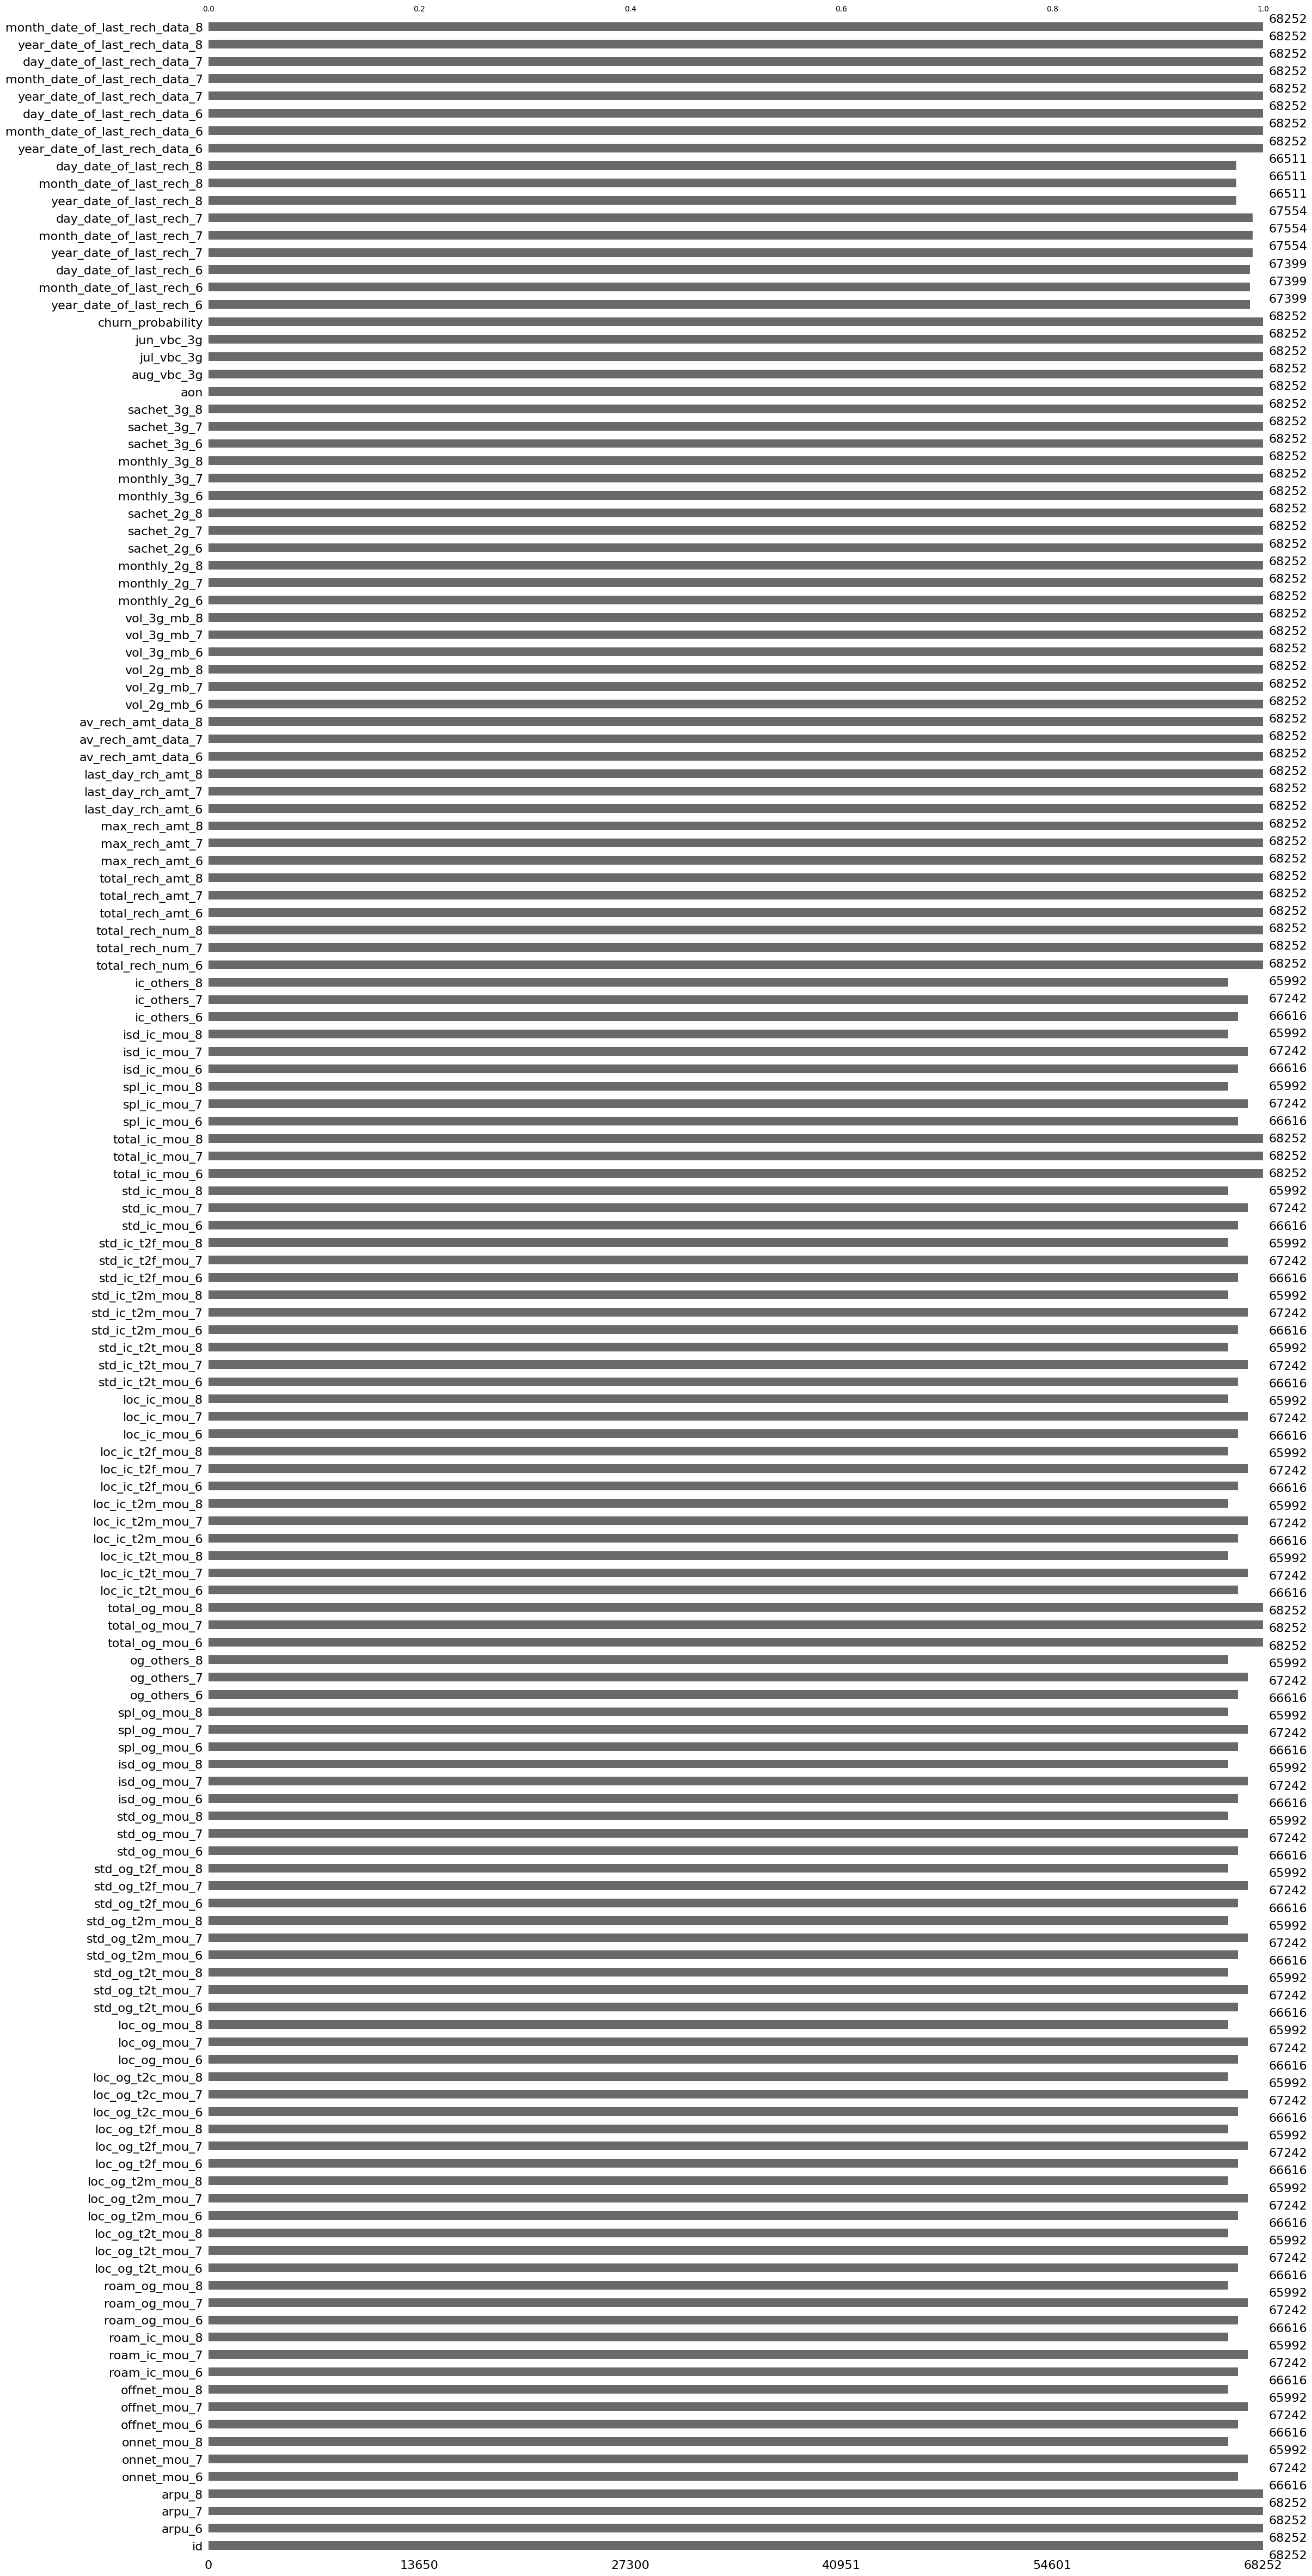

In [545]:
msno.bar(X)

<Axes: >

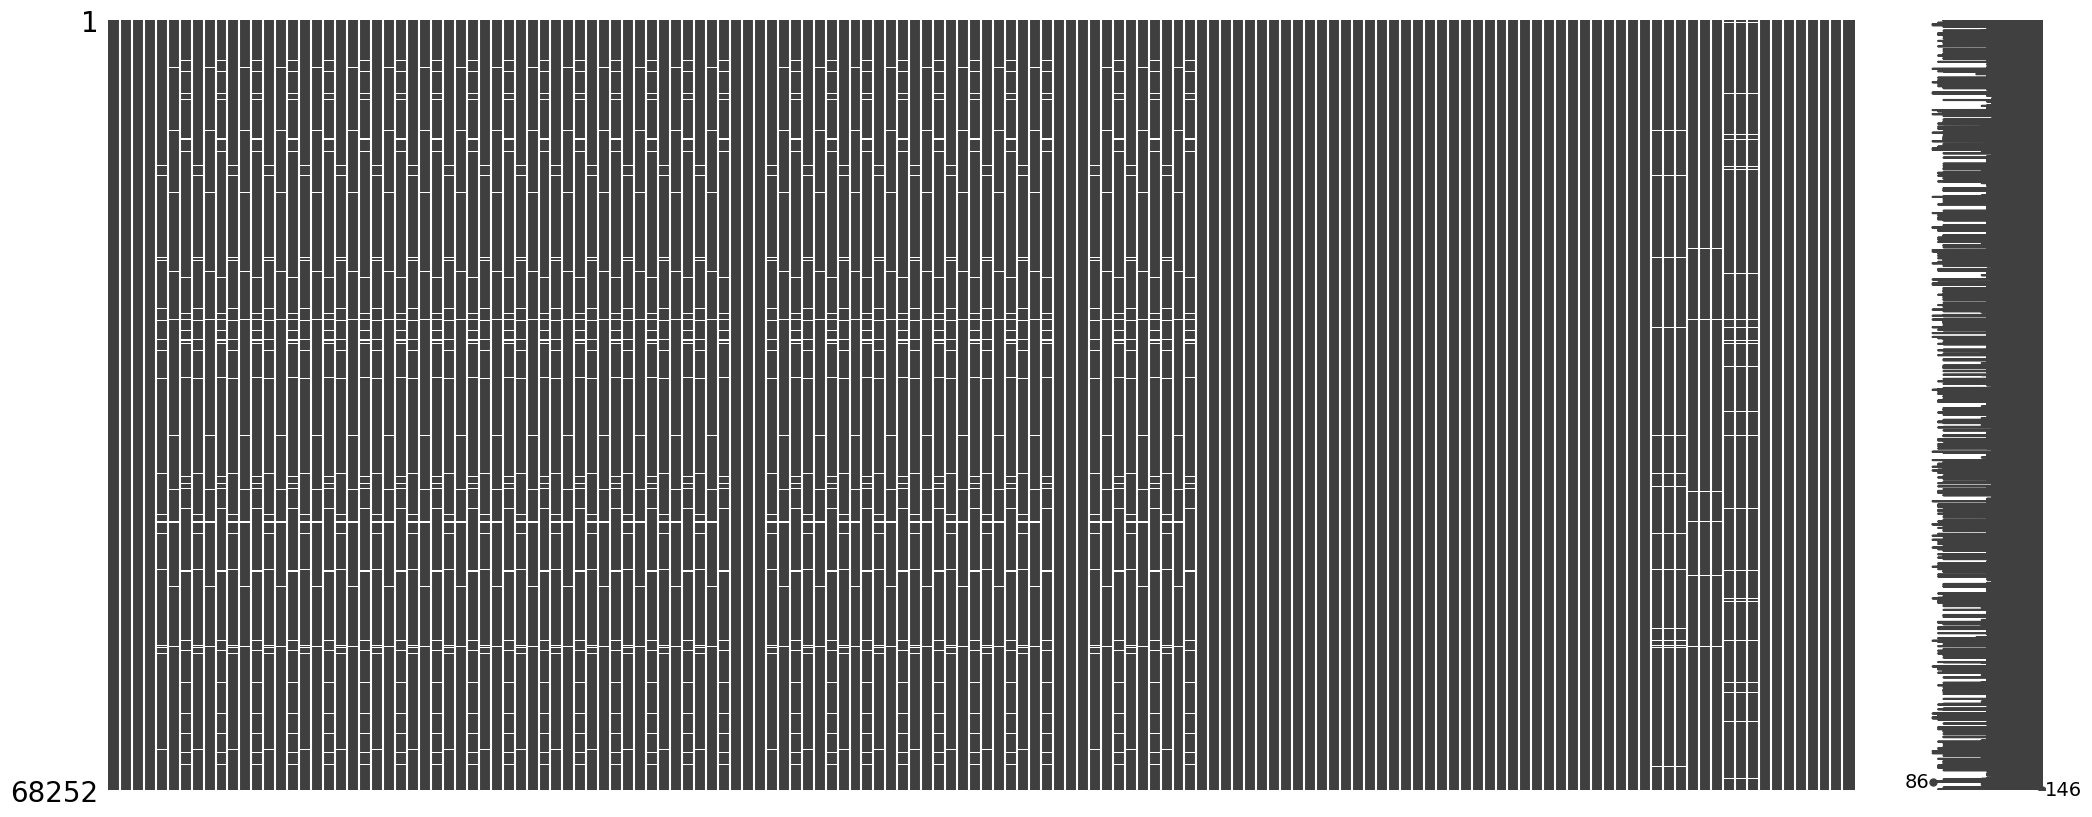

In [546]:
msno.matrix(X)

Lets also calculate the % missing data for each column:

In [547]:
missing_data_percent = 100*X.isnull().sum()/len(y)
missing_data_percent

id                                0.000000
arpu_6                            0.000000
arpu_7                            0.000000
arpu_8                            0.000000
onnet_mou_6                       2.396999
                                    ...   
year_date_of_last_rech_data_7     0.000000
month_date_of_last_rech_data_7    0.000000
day_date_of_last_rech_data_7      0.000000
year_date_of_last_rech_data_8     0.000000
month_date_of_last_rech_data_8    0.000000
Length: 146, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [548]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'month_date_of_last_rech_8', 'day_date_of_last_rech_8',
       'year_date_of_last_rech_data_6', 'month_date_of_last_rech_data_6',
       'day_date_of_last_rech_data_6', 'year_date_of_last_rech_data_7',
       'month_date_of_last_rech_data_7', 'day_date_of_last_rech_data_7',
       'year_date_of_last_rech_data_8', 'month_date_of_last_rech_data_8'],
      dtype='object', length=146)

In [549]:
X_filtered = X[new_vars]
X_filtered.shape

(68252, 146)

In [550]:
# Calculating the missing value percentage on the train set
missing_data_percent = X_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In our case, the values are missing because some of the customers have not used features such as 'calls within same network operator', 'calls outside the operator T Network' etc.
Hence these are meaningful and can be replaced with 0.

In [551]:
# Replacing the missing values with constant 0.
imp = SimpleImputer(strategy='constant', fill_value=0)
X_filtered[impute_cols] = imp.fit_transform(X_filtered[impute_cols])

<Axes: >

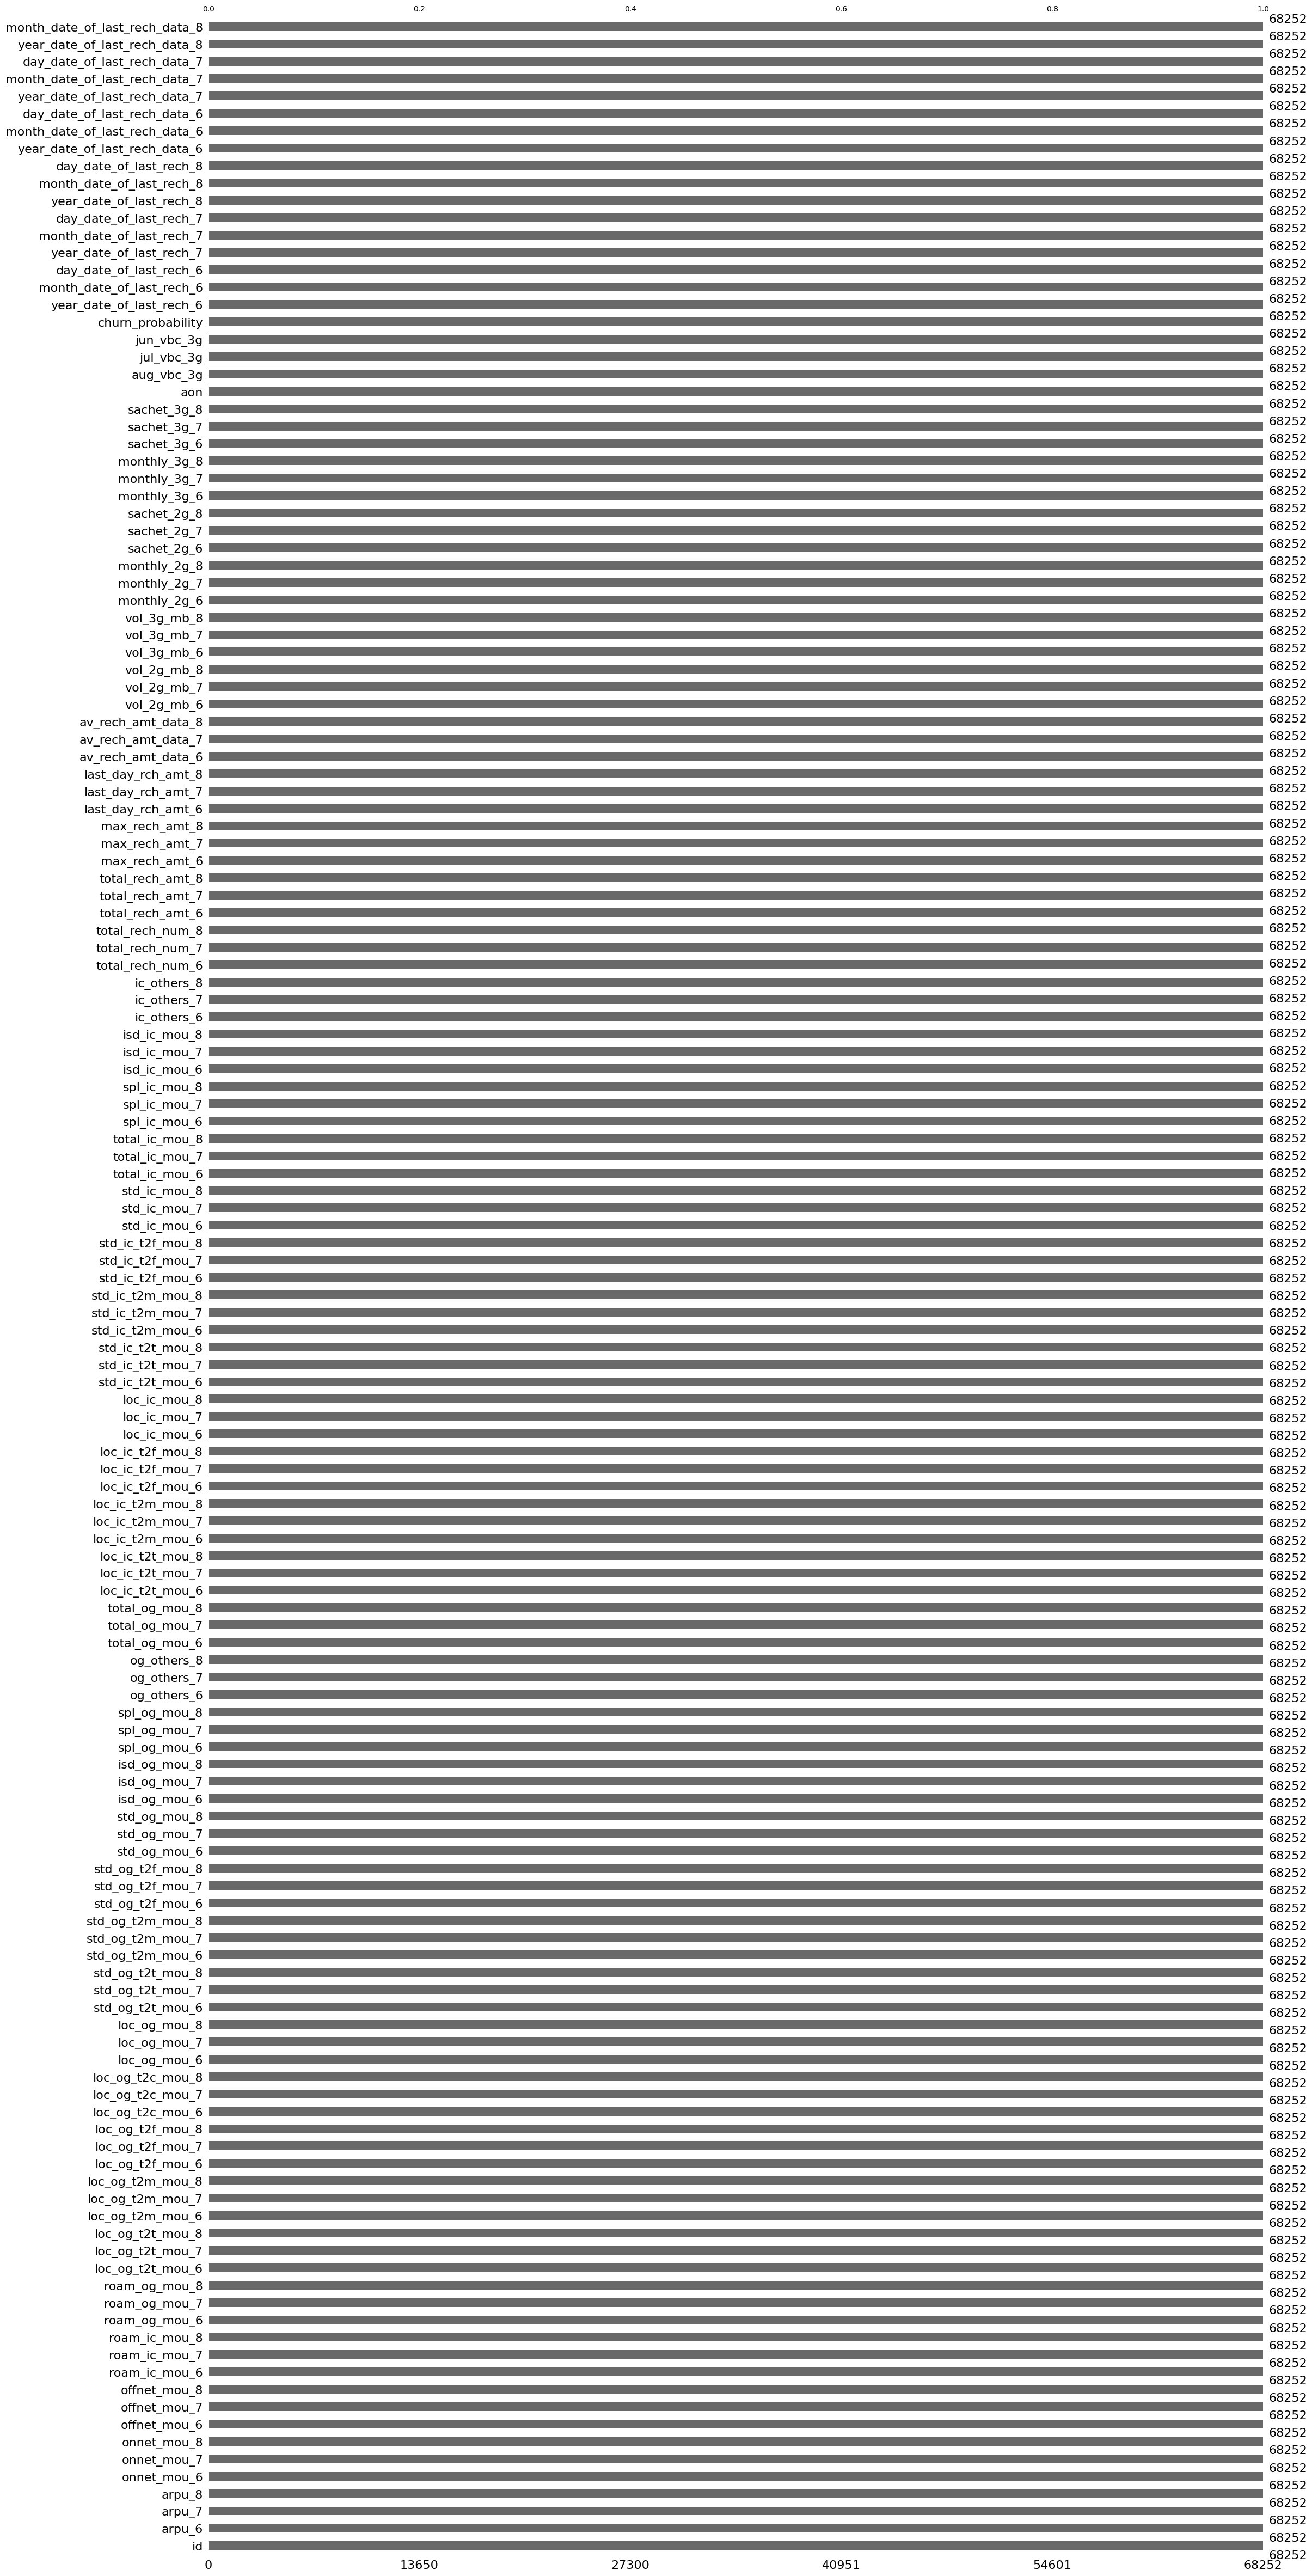

In [552]:
# Rechecking the value count for missing values
msno.bar(X_filtered)

We do not see any missing values in our training data set now.

In [553]:
# Summarizing the cleaned dataset
X_filtered.describe()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,month_date_of_last_rech_8,day_date_of_last_rech_8,year_date_of_last_rech_data_6,month_date_of_last_rech_data_6,day_date_of_last_rech_data_6,year_date_of_last_rech_data_7,month_date_of_last_rech_data_7,day_date_of_last_rech_data_7,year_date_of_last_rech_data_8,month_date_of_last_rech_data_8
count,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,...,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000,68252.000000
mean,34981.061581,285.171912,283.558300,283.482732,129.723777,131.980367,128.487570,193.951733,194.278465,190.048448,...,7.795933,24.867037,1981.148274,2.266849,5.577009,1981.351990,2.547999,5.848840,1981.722030,2.864868
std,20204.703134,332.470986,345.859195,353.962344,296.790001,309.506017,307.577363,314.393988,321.061509,320.797527,...,1.261316,7.172443,19.137539,2.174720,8.950534,19.251631,2.625222,9.365881,19.451706,3.094590
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000
25%,17491.750000,95.109750,91.397500,88.083250,6.190000,5.980000,4.980000,31.140000,30.125000,26.580000,...,8.000000,24.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000
50%,34967.500000,199.268500,196.642500,196.167500,31.980000,31.100000,29.410000,92.310000,89.360000,86.030000,...,8.000000,27.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000
75%,52475.250000,372.976000,370.191750,374.656500,114.910000,112.965000,109.560000,227.195000,223.967500,221.045000,...,8.000000,30.000000,2014.000000,6.000000,2.000000,2014.000000,7.000000,3.000000,2014.000000,8.000000
max,69998.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,...,8.000000,31.000000,2014.000000,6.000000,30.000000,2014.000000,7.000000,31.000000,2014.000000,8.000000


In [554]:
#Splitting into train and test
X_train_filtered, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train_filtered.shape, X_test.shape, y_train.shape, y_test.shape

((54601, 146), (13651, 146), (54601,), (13651,))

# 4. Exploratory Data Analysis & Preprocessing



### 4.1 Handling outliers

Before we start the EDA, we need to check for all outliners in the dataset as it can impact on the accuracy of our analysis. 
For our analysis, we have used k-sigma method to cap the outliners.

In [555]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
X_train_filtered.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,month_date_of_last_rech_8,day_date_of_last_rech_8,year_date_of_last_rech_data_6,month_date_of_last_rech_data_6,day_date_of_last_rech_data_6,year_date_of_last_rech_data_7,month_date_of_last_rech_data_7,day_date_of_last_rech_data_7,year_date_of_last_rech_data_8,month_date_of_last_rech_data_8
count,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,...,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000,54601.000000
mean,34946.949305,285.699707,283.853079,283.665682,129.175948,131.617500,128.511486,194.446437,194.977160,190.413983,...,7.797513,24.876870,1981.140822,2.266002,5.560924,1981.362429,2.549422,5.837860,1981.675098,2.857402
std,20221.003027,340.225511,352.896474,355.381446,294.843731,306.952377,307.471316,316.436660,324.200242,318.703366,...,1.256553,7.149676,19.133347,2.174244,8.924736,19.257437,2.626014,9.354486,19.426871,3.090639
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000
25%,17440.000000,95.078000,91.708000,87.885000,6.230000,5.910000,5.010000,31.160000,30.280000,26.490000,...,8.000000,24.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000
50%,34930.000000,198.963000,197.100000,196.505000,32.010000,31.080000,29.460000,92.560000,89.460000,86.040000,...,8.000000,27.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000,1.000000,1970.000000,1.000000
75%,52419.000000,373.744000,371.062000,374.726000,114.580000,113.060000,109.560000,227.690000,224.310000,221.840000,...,8.000000,30.000000,2014.000000,6.000000,2.000000,2014.000000,7.000000,3.000000,2014.000000,8.000000
90%,62993.000000,624.854000,621.972000,622.496000,336.310000,343.780000,335.290000,474.180000,476.810000,475.730000,...,8.000000,31.000000,2014.000000,6.000000,24.000000,2014.000000,7.000000,25.000000,2014.000000,8.000000
95%,66476.000000,835.432000,826.750000,836.070000,605.410000,616.130000,604.910000,727.810000,745.790000,731.180000,...,8.000000,31.000000,2014.000000,6.000000,28.000000,2014.000000,7.000000,29.000000,2014.000000,8.000000
99%,69311.000000,1406.705000,1429.299000,1452.234000,1420.990000,1473.130000,1461.840000,1534.580000,1542.790000,1500.410000,...,8.000000,31.000000,2014.000000,6.000000,30.000000,2014.000000,7.000000,31.000000,2014.000000,8.000000


In [556]:
# Function to cap the outliners
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [557]:
# Removing the outliners
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)
X_train_filtered1

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,month_date_of_last_rech_8,day_date_of_last_rech_8,year_date_of_last_rech_data_6,month_date_of_last_rech_data_6,day_date_of_last_rech_data_6,year_date_of_last_rech_data_7,month_date_of_last_rech_data_7,day_date_of_last_rech_data_7,year_date_of_last_rech_data_8,month_date_of_last_rech_data_8
32119,32119,137.608,129.838,180.202,12.61,14.93,13.080000,142.610000,124.490000,182.94,...,8.000000,20.000000,1970,1,1,1970,1,1,1970,1
58682,58682,110.116,134.448,78.010,0.25,0.00,0.000000,3.980000,13.560000,7.63,...,8.000000,24.000000,2014,6,27,2014,7,10,2014,8
15255,15255,571.734,699.324,386.000,40.88,134.44,9.390000,579.160000,599.180000,270.78,...,4.027854,3.427844,1970,1,1,1970,1,1,1970,1
69201,69201,149.518,0.000,17.400,0.00,0.00,0.960000,99.440000,0.000000,50.06,...,8.000000,5.000000,1970,1,1,1970,1,1,1970,1
11571,11571,436.571,536.553,468.867,108.44,331.76,78.160000,1007.780000,1113.590000,1084.96,...,8.000000,25.000000,1970,1,1,1970,1,1,1970,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68788,68788,129.937,419.101,359.052,48.73,36.39,92.740000,270.410000,209.860000,309.91,...,8.000000,30.000000,1970,1,1,2014,7,3,1970,1
5085,5085,652.363,908.947,249.428,9.39,7.48,2.060000,1143.756416,1167.577885,507.61,...,8.000000,26.000000,1970,1,1,1970,1,1,2014,8
61352,61352,329.923,348.462,258.418,80.63,155.78,126.590000,276.730000,282.860000,231.48,...,8.000000,14.000000,1970,1,1,1970,1,1,1970,1
45637,45637,218.941,274.226,402.884,28.81,15.99,29.880000,156.960000,194.880000,210.53,...,8.000000,29.000000,2014,6,1,2014,7,26,2014,8


### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler 

In [558]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

### 4.3 Univariate Analysis

We will now perform univariate analysis on the features to check if they have any visible pattern with respect to the churn rate.

Text(0.5, 1.0, 'Count of CHURN variable')

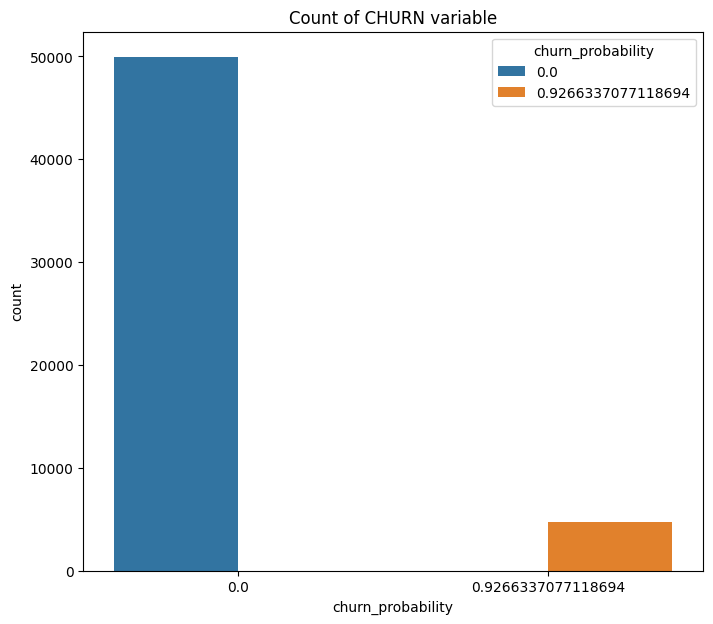

In [559]:
# Checking the distribution of Churned customers in the training dataset.
plt.figure(figsize=(8,7))
sns.countplot(x='churn_probability', data=X_train_filtered1 , hue='churn_probability')
plt.title("Count of CHURN variable")

Number of customers with high churn probability seems less in the training dataset.

In [560]:
X_train_filtered1.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'month_date_of_last_rech_8', 'day_date_of_last_rech_8',
       'year_date_of_last_rech_data_6', 'month_date_of_last_rech_data_6',
       'day_date_of_last_rech_data_6', 'year_date_of_last_rech_data_7',
       'month_date_of_last_rech_data_7', 'day_date_of_last_rech_data_7',
       'year_date_of_last_rech_data_8', 'month_date_of_last_rech_data_8'],
      dtype='object', length=146)

In [561]:
# Checking if the churn probability depends on Average revenue per user , total recharge and max recharge amount

# Deriving columns for the univariate analysis
X_train_filtered1['average_Rev_per_user'] = X_train_filtered1['arpu_6'] + X_train_filtered1['arpu_7'] + X_train_filtered1['arpu_8']
X_train_filtered1['total_recharge_amnt'] = X_train_filtered1['total_rech_amt_6'] + X_train_filtered1['total_rech_amt_7'] + X_train_filtered1['total_rech_amt_8']
X_train_filtered1['max_rech_amt'] = X_train_filtered1['max_rech_amt_6'] + X_train_filtered1['max_rech_amt_7'] + X_train_filtered1['max_rech_amt_8']

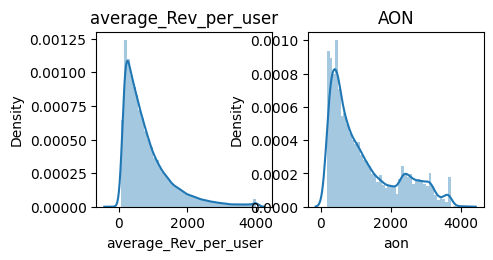

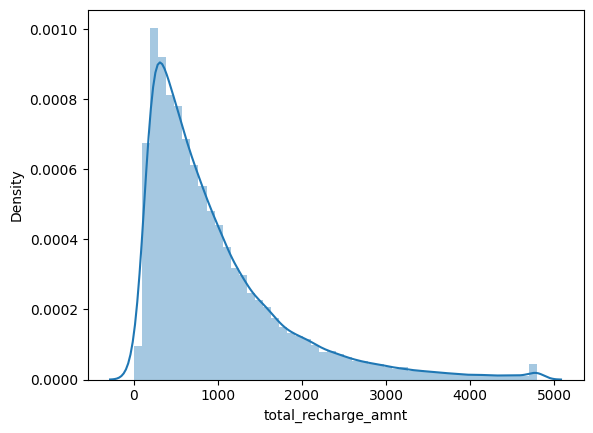

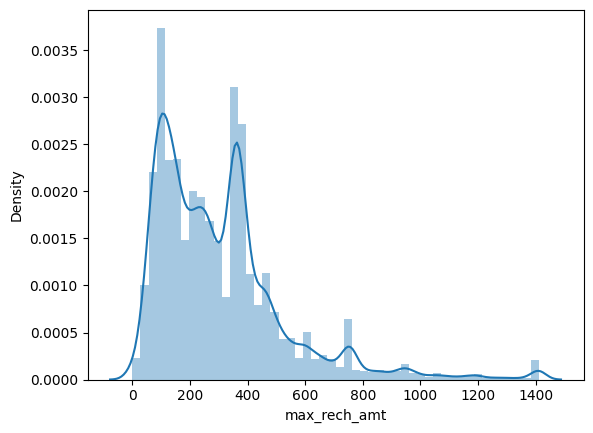

In [562]:
# Data plotting for visualization 
fig = plt.figure(figsize=(5,5))

# Plot histogram with kde - Average Revenue per user
ax1 = fig.add_subplot(2, 2, 1)
ax1.set(title = 'average_Rev_per_user')
sns.distplot(X_train_filtered1['average_Rev_per_user'])
    
# Plot histogram with kde - Age on network 
ax2 = fig.add_subplot(2, 2, 2)
sns.distplot(X_train_filtered1['aon'])
ax2.set(title = 'AON')
plt.show()  

# Plot histogram with kde - Total Recharge Amount
ax2 = fig.add_subplot(2, 2, 3)
sns.distplot(X_train_filtered1['total_recharge_amnt'])
ax2.set(title = 'Total Recharge Amount')
plt.show()  

# Plot histogram with kde - Max Recharge Amount
ax2 = fig.add_subplot(2, 2, 4)
sns.distplot(X_train_filtered1['max_rech_amt'])
ax2.set(title = 'Maximum Recharge Amount')
plt.show()  

All the features show right skewed distribution. We can not use any Linear Regression Model here. Log transformation can be a good choice here.

### 4.4 Bivariate Analysis

<Axes: >

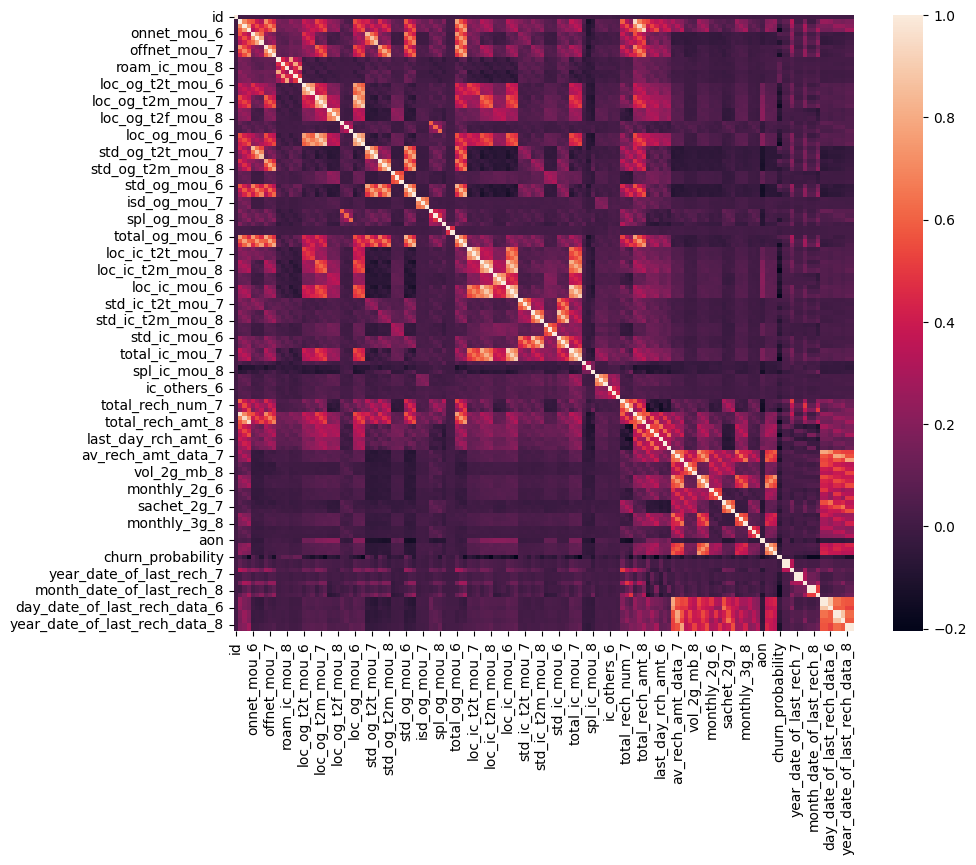

In [563]:
# Checking correlation among independent variables
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered1, columns=new_vars).corr())

Too many features show high correlation among each other, therefore we need to perform dimentionality reduction.

# 5. Feature engineering and selection

For our analysis we are using Principal Component Analysis for dimentionality reduction.

In [564]:
# Instantiate PCA
pca = PCA(random_state=42)

In [565]:
# Fit train set on PCA
pca.fit(X_train_filtered2)

PCA(random_state=42)

In [566]:
# Check principal components
pca.components_

array([[ 1.46356907e-03,  1.66093390e-01,  1.77228885e-01, ...,
         6.98539745e-02,  7.69002823e-02,  7.69002823e-02],
       [ 9.07307738e-04, -3.12028468e-02, -3.95039228e-02, ...,
         1.78857644e-01,  1.75785132e-01,  1.75785132e-01],
       [-2.09234262e-04,  6.26896213e-02,  8.40096186e-02, ...,
         8.94105077e-02,  8.41116023e-02,  8.41116023e-02],
       ...,
       [ 0.00000000e+00, -7.82472923e-18, -9.05399393e-17, ...,
         3.33473336e-17,  3.45398008e-01, -3.45398008e-01],
       [-0.00000000e+00,  1.62313937e-16,  1.67820061e-16, ...,
         7.69035254e-17, -5.03751604e-01,  5.03751604e-01],
       [-0.00000000e+00,  6.23398681e-17,  8.64106564e-17, ...,
         3.18186731e-17,  2.97034819e-01, -2.97034819e-01]])

In [567]:
# Checl Cumuliative varinace of the PCs
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.14157187, 0.23056093, 0.30341948, 0.3437409 , 0.38012841,
       0.4081284 , 0.4337787 , 0.45635097, 0.47797649, 0.49913426,
       0.51799109, 0.53641746, 0.55352004, 0.56949688, 0.58445034,
       0.59932655, 0.61370383, 0.6274429 , 0.6405589 , 0.65272236,
       0.6643991 , 0.67529293, 0.68575516, 0.69593973, 0.70602984,
       0.71577609, 0.72468981, 0.73350388, 0.74182132, 0.75004938,
       0.75821048, 0.76590936, 0.77321196, 0.78009878, 0.7868664 ,
       0.79319373, 0.79941917, 0.8054279 , 0.81136868, 0.81722774,
       0.82292104, 0.82852682, 0.83392074, 0.83904106, 0.8440997 ,
       0.84897969, 0.8537378 , 0.85830071, 0.8628122 , 0.8672729 ,
       0.87156036, 0.87566194, 0.87956988, 0.88342297, 0.88712751,
       0.89079724, 0.89441422, 0.8979324 , 0.90144198, 0.9048277 ,
       0.90815908, 0.91146208, 0.91461536, 0.91766122, 0.92062723,
       0.9234213 , 0.92619474, 0.92894486, 0.93161762, 0.93418192,
       0.93665621, 0.93902968, 0.94133291, 0.9436125 , 0.94584

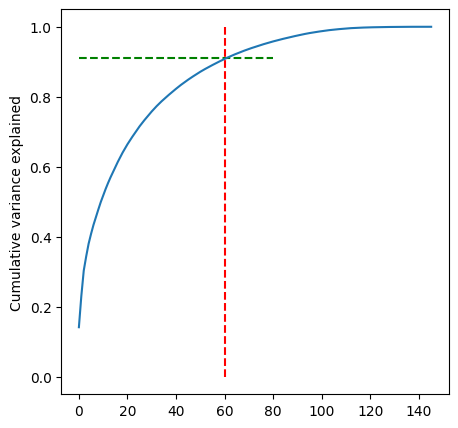

In [568]:
# Plotting Scree plot
fig = plt.figure(figsize=[5,5])
plt.vlines(x=60, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.91, xmax=80, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Approx. 90% variance of data is explained with 60 components, hence we can use PCA with 60 components for our dataset.

In [569]:
# PCA with 60 components
pca_60 = PCA(n_components=60, random_state=42)

In [570]:
# Fit and transform the X_train
X_train_pca = pca_60.fit_transform(X_train_filtered2)

In [571]:
# Checking the dimension of new data
X_train_pca.shape

(54601, 60)

In [572]:
# Applying PCA transformation on our test data
X_test_pca = pca_60.transform(X_test)

# 6. Model building

### 6.1 PCA with Logistic Regression

Our objective is to predict a categorical dependent variable using a given set of independent variables, hence we need to build a classification model. Here we are building a logistic Regression model with hypertuning.

In [573]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params

params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}


# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [574]:
# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [575]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.509790,0.105813,0.006384,0.001354,0.01,{'C': 0.01},0.753319,0.765568,0.757784,0.757509,...,0.758081,0.004064,6,0.766415,0.763719,0.765024,0.765894,0.765688,0.765348,0.000929
1,3.199610,0.283694,0.005133,0.000866,0.1,{'C': 0.1},0.758996,0.769322,0.761722,0.762729,...,0.762752,0.003506,5,0.773375,0.770655,0.773059,0.771777,0.772830,0.772339,0.000998
2,3.416034,0.165056,0.006147,0.001652,1,{'C': 1},0.762934,0.774084,0.765476,0.766484,...,0.766872,0.003790,4,0.778480,0.775692,0.778279,0.777615,0.777913,0.777596,0.000997
3,3.323855,0.242865,0.004962,0.000636,10,{'C': 10},0.763117,0.774725,0.766575,0.767491,...,0.767587,0.003858,3,0.779167,0.776676,0.779080,0.778554,0.779080,0.778511,0.000943
4,3.042925,0.300380,0.004403,0.000789,100,{'C': 100},0.764124,0.775366,0.767399,0.766758,...,0.767971,0.003857,1,0.779762,0.776882,0.778828,0.778050,0.778485,0.778402,0.000946
5,2.972310,0.111623,0.004474,0.000538,1000,{'C': 1000},0.763392,0.775733,0.766850,0.766758,...,0.767916,0.004128,2,0.779670,0.776402,0.779469,0.778370,0.778851,0.778553,0.001170


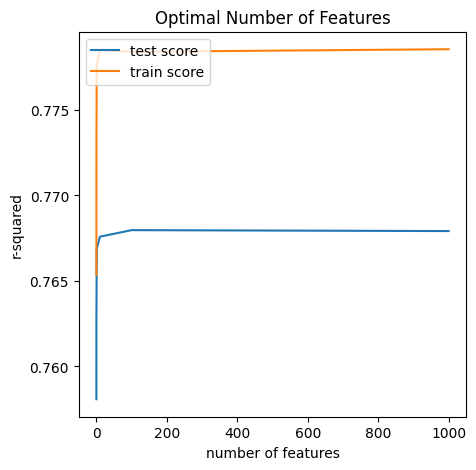

In [576]:
# plotting cv results
plt.figure(figsize=(5,5))

plt.plot(cv_results["param_C"], cv_results["mean_test_score"])
plt.plot(cv_results["param_C"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [577]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.509790,0.105813,0.006384,0.001354,0.01,{'C': 0.01},0.753319,0.765568,0.757784,0.757509,...,0.758081,0.004064,6,0.766415,0.763719,0.765024,0.765894,0.765688,0.765348,0.000929
1,3.199610,0.283694,0.005133,0.000866,0.1,{'C': 0.1},0.758996,0.769322,0.761722,0.762729,...,0.762752,0.003506,5,0.773375,0.770655,0.773059,0.771777,0.772830,0.772339,0.000998
2,3.416034,0.165056,0.006147,0.001652,1,{'C': 1},0.762934,0.774084,0.765476,0.766484,...,0.766872,0.003790,4,0.778480,0.775692,0.778279,0.777615,0.777913,0.777596,0.000997
3,3.323855,0.242865,0.004962,0.000636,10,{'C': 10},0.763117,0.774725,0.766575,0.767491,...,0.767587,0.003858,3,0.779167,0.776676,0.779080,0.778554,0.779080,0.778511,0.000943
4,3.042925,0.300380,0.004403,0.000789,100,{'C': 100},0.764124,0.775366,0.767399,0.766758,...,0.767971,0.003857,1,0.779762,0.776882,0.778828,0.778050,0.778485,0.778402,0.000946
5,2.972310,0.111623,0.004474,0.000538,1000,{'C': 1000},0.763392,0.775733,0.766850,0.766758,...,0.767916,0.004128,2,0.779670,0.776402,0.779469,0.778370,0.778851,0.778553,0.001170


In [578]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

best_C

100

Now we can choose the optimal value of number of features and build a final model.

In [579]:
# final model
n_features_optimal = 100

lmg = LogisticRegression(C=n_features_optimal)
# Fit the model on the train set
log_pca_model = lmg.fit(X_train_pca, y_train)

In [580]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_pca)

In [581]:
# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

Model evaluation:

In [582]:
# Confusion matrix - Training Data
confusion = metrics.confusion_matrix(y_train, y_train_pred)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives



In [583]:
# Metrics for Training data
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.7780626728448197
Sensitivity:- 0.41935483870967744
Specificity:- 0.9999501719069211


In [584]:
# Confusion matrix - Test Data
confusion = metrics.confusion_matrix(y_test, y_test_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [585]:
# Metrics for Test Data
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.019998534905867702
Sensitivity:- nan
Specificity:- nan


<span style="color:DarkBlue">

<b>Observations:</b>
- Confusion metric drops significantly for test data
- Model can not handle the variances in features
</span>

Let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model


In [586]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=60)
lr = LogisticRegression(max_iter=1000, tol=0.001,C=100)

In [587]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [588]:
pipe.fit(X_train_filtered1[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=60)),
                ('model', LogisticRegression(C=100, max_iter=1000, tol=0.001))])

In [589]:
train_score = pipe.score(X_train_filtered1[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.7787220014285453


In [590]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.7623617317412644


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [591]:
confusion_matrix(y_train, pipe.predict(X_train_filtered1[new_vars]))

array([[40136,     4,     3,     2,     8,     3,     2,     6,    11,
            5,     5,     4,     3,     3,     7,     4,     1,     3,
            2,     0,     0,     1,     1,     9,    16,     4,     3,
            5,    12,    10,    17],
       [   21,     9,     6,     5,    15,     7,     4,    17,    18,
            6,    16,     4,     1,     2,     9,     6,     2,     3,
            1,     1,     2,     0,     2,     3,     9,     4,     5,
            5,    12,    16,    17],
       [   24,     6,     7,     5,    16,     3,     3,     9,    11,
            9,    17,     5,     3,     0,     5,     8,     2,     3,
            8,     3,     3,     1,     6,    13,    15,     3,     6,
            4,     9,    15,    18],
       [   20,    12,     2,    16,    18,     5,     6,    11,    17,
            2,    18,     4,     6,     6,    10,     8,     1,     9,
            9,     3,     1,     2,     7,     9,    12,     5,     9,
            9,    19,     9,    28],


In [592]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[9933,    3,    0,    2,    6,    2,    4,    8,    3,    3,    4,
           2,    3,    0,    0,    6,    1,    2,    2,    0,    0,    0,
           1,    0,    1,    1,    0,    0,    3,    4,    8],
       [   6,    0,    0,    1,    5,    1,    3,    2,    3,    1,    1,
           3,    1,    0,    4,    0,    2,    0,    1,    1,    2,    1,
           1,    1,    4,    0,    0,    3,    3,    6,    2],
       [  10,    1,    0,    1,    0,    3,    0,    3,   10,    1,    3,
           3,    1,    1,    0,    2,    0,    2,    0,    2,    2,    1,
           1,    2,    2,    0,    1,    0,    2,    6,    7],
       [   5,    2,    1,    2,    6,    5,    1,    5,    2,    1,    5,
           3,    0,    1,    3,    3,    2,    1,    2,    1,    1,    2,
           1,    2,    2,    2,    0,    3,    5,    6,    5],
       [   4,    3,    2,    1,    7,    2,    4,    5,    7,    1,   10,
           2,    4,    0,    4,    2,    1,    3,    0,    2,    1,    1,
        

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [593]:
precision_score(y_test, pipe.predict(X_test[new_vars]),average='micro')

0.7623617317412644

In [594]:
recall_score(y_test, pipe.predict(X_test[new_vars]),average='micro')

0.7623617317412644

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [595]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [596]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [597]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

KeyError: "['id', 'churn_probability', 'year_date_of_last_rech_6', 'month_date_of_last_rech_6', 'day_date_of_last_rech_6', 'year_date_of_last_rech_7', 'month_date_of_last_rech_7', 'day_date_of_last_rech_7', 'year_date_of_last_rech_8', 'month_date_of_last_rech_8', 'day_date_of_last_rech_8', 'year_date_of_last_rech_data_6', 'month_date_of_last_rech_data_6', 'day_date_of_last_rech_data_6', 'year_date_of_last_rech_data_7', 'month_date_of_last_rech_data_7', 'day_date_of_last_rech_data_7', 'year_date_of_last_rech_data_8', 'month_date_of_last_rech_data_8'] not in index"

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.